## Họ và tên: Nguyễn Mạnh Niên
## Mã sinh viên: 20226019541

In [1]:
# Cài đặt các thư viện cần thiết
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import csv
warnings.filterwarnings("ignore") # Loại bỏ các cảnh báo
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
# Khai báo các giá trị tham số cố định
PATH_FILE       = '/kaggle/input/dataa/data.csv' # Đường dẫn đến file dữ liệu
K_FOLD          = 4                 # Dùng trong đánh giá kiểm định chéo
DPI             = 200               # Độ phân giải cho biểu đồ

### a. Đọc dữ liệu từ tệp cho trước và thực hiện phép chuẩn hóa theo phương pháp min-max

In [3]:
# Đọc dữ liệu sử dụng pandas
try:
    # Đọc file CSV
    df = pd.read_csv(PATH_FILE,
                     header = 0, 
                     sep = ',',
                     skipinitialspace = True)
    print('Đọc file thành công!')
    print(df.head(5))   # In ra 5 dòng đầu tiên
except FileNotFoundError:
    print(f"Lỗi: File '{PATH_FILE}' không tồn tại.")
except Exception:
    print(f"Lỗi {Exception}.")

Đọc file thành công!
     X    Y    Z    T    U     V    F Class
0  5.8  1.5  1.6  8.1  1.1   6.1  4.2     x
1  1.3  4.6  3.1  2.2  2.9   9.1  5.8     o
2  1.3  4.4  2.8  3.0  2.5  10.0  3.2     x
3  1.6  3.8  2.9  2.2  2.7  11.0  7.0     o
4  5.8  1.3  3.5  3.9  1.3   5.2  3.3     x


In [4]:
# Kiểm tra xem dữ liệu có bị thiếu hay không
check_nan = df.isna().any().any()
if check_nan == True:
    print("Dữ liệu bị thiếu!")
else:
    print("Dữ liệu đầy đủ!")

Dữ liệu đầy đủ!


In [5]:
# Chuyển đổi các thuộc tính dạng ký tự sang số
Le = LabelEncoder()
df['Class'] = Le.fit_transform(df['Class'])

In [6]:
# Chuẩn hóa Min-Max
# Lấy dữ liệu chuẩn hóa từ DataFrame
df_X = df.iloc[:, :-1]
df_y = df.iloc[:, -1]

# Chuẩn hóa dữ liệu
scaler  = MinMaxScaler()
df_X    = scaler.fit_transform(df_X)

In [7]:
# Hiển thị dữ liệu đã chuẩn hóa
X = pd.DataFrame(df_X, columns=df.columns[: -1])
print(X)

           X         Y         Z         T         U         V     F
0   0.703125  0.060606  0.038462  1.000000  0.000000  0.473118  0.44
1   0.000000  1.000000  0.615385  0.000000  0.439024  0.795699  0.76
2   0.000000  0.939394  0.500000  0.135593  0.341463  0.892473  0.24
3   0.046875  0.757576  0.538462  0.000000  0.390244  1.000000  1.00
4   0.703125  0.000000  0.769231  0.288136  0.048780  0.376344  0.26
5   0.859375  0.696970  0.307692  0.423729  0.292683  0.440860  0.14
6   0.500000  0.090909  0.000000  0.322034  0.024390  0.849462  0.00
7   0.234375  0.757576  0.384615  0.288136  0.682927  0.860215  0.14
8   0.093750  0.393939  0.538462  0.067797  0.243902  0.000000  0.12
9   0.859375  0.878788  0.538462  0.288136  0.170732  0.075269  0.38
10  0.140625  0.484848  1.000000  0.016949  1.000000  0.397849  0.38
11  1.000000  0.030303  0.384615  0.152542  0.097561  0.602151  0.46


### b. Chuẩn bị dữ liệu cho quá trình thực hiện sử dụng phương pháp K-Fold với k = 3

In [8]:
# Câu b: Chuẩn bị dữ liệu theo phương pháp kiểm định chéo k-folds
data_fold = {               # chứa dữ liệu của từng fold
    'X_train':[],           # Chứa X_train của từng fold
    'y_train' : [],         # Chứa y_train của từng fold
    'X_test' : [],          # Chứa X_test của từng fold
    'y_test' : []           # Chứa y_test của từng fold
}  

# Khởi tạo k fold
kf = KFold(n_splits = K_FOLD)
# Chia dữ liệu theo từng fold
for train_index, test_index in kf.split(df_X):
    data_fold['X_train'].append(df_X[train_index])
    data_fold['X_test'].append(df_X[test_index])
    data_fold['y_train'].append(df_y[train_index])
    data_fold['y_test'].append(df_y[test_index])


### c. Xây dựng mô hình Naive-bayes

In [9]:
# Khởi tạo dict chứa các chỉ số đánh giá của mô hình
parameters_bayes = {
    'accuracy' : [],
    'recall' : [],
    'precision' : [],
    'f1-score' : [],
    'execution-time' : []
}

In [10]:
for i in range(K_FOLD):
    # Khởi tạo mô hình Naive-bayes
    clf_bayes = GaussianNB()

    start_bayes = time.time()       # Bắt đầu ghi thời gian huấn luyện
    # Huấn luyện mô hình
    clf_bayes.fit(data_fold['X_train'][i], data_fold['y_train'][i])
    execution_time_bayes = time.time() - start_bayes       # Kết thúc thời gian huấn luyện
    
    # Dự đoán kết quả
    y_pred_bayes = clf_bayes.predict(data_fold['X_test'][i])

    # Tính các chỉ số đánh giá mô hình
    acc = accuracy_score(data_fold['y_test'][i], y_pred_bayes)
    rec = recall_score(data_fold['y_test'][i], y_pred_bayes)
    f1 = f1_score(data_fold['y_test'][i], y_pred_bayes)
    pre = precision_score(data_fold['y_test'][i], y_pred_bayes)

    # Lưu kết quả vào mảng
    parameters_bayes['accuracy'].append(acc)
    parameters_bayes['recall'].append(rec)
    parameters_bayes['precision'].append(pre)
    parameters_bayes['f1-score'].append(f1)
    parameters_bayes['execution-time'].append(execution_time_bayes)

    # In ra kết quả theo từng Fold
    print("FOLD:", i + 1)  # In số thứ tự của fold
    # Các chỉ số đánh giá
    print("{:<15}{:<15}{:<15}{:<15}{:<15}".format("Precision", "Recall", "F1-Score", "Accuracy", 'Execution Time'))
    # In kết quả
    print("{:<15}{:<15}{:<15}{:<15}{:<15}".format(
        f"{pre * 100:.4}%", f"{rec * 100:.4}%", f"{f1 * 100:.4}%", f"{acc * 100:.4}%", f"{execution_time_bayes:.4}s"
    ))
    print('-' * 80)

FOLD: 1
Precision      Recall         F1-Score       Accuracy       Execution Time 
100.0%         100.0%         100.0%         100.0%         0.00113s       
--------------------------------------------------------------------------------
FOLD: 2
Precision      Recall         F1-Score       Accuracy       Execution Time 
100.0%         100.0%         100.0%         100.0%         0.001193s      
--------------------------------------------------------------------------------
FOLD: 3
Precision      Recall         F1-Score       Accuracy       Execution Time 
66.67%         100.0%         80.0%          66.67%         0.0008638s     
--------------------------------------------------------------------------------
FOLD: 4
Precision      Recall         F1-Score       Accuracy       Execution Time 
66.67%         100.0%         80.0%          66.67%         0.0008521s     
--------------------------------------------------------------------------------


In [11]:
# Tính trung bình các chỉ số
acc_bayes = np.mean(parameters_bayes['accuracy'])
rec_bayes = np.mean(parameters_bayes['recall'])
pre_bayes = np.mean(parameters_bayes['precision'])
f1_bayes = np.mean(parameters_bayes['f1-score'])
execution_bayes = np.mean(parameters_bayes['execution-time'])

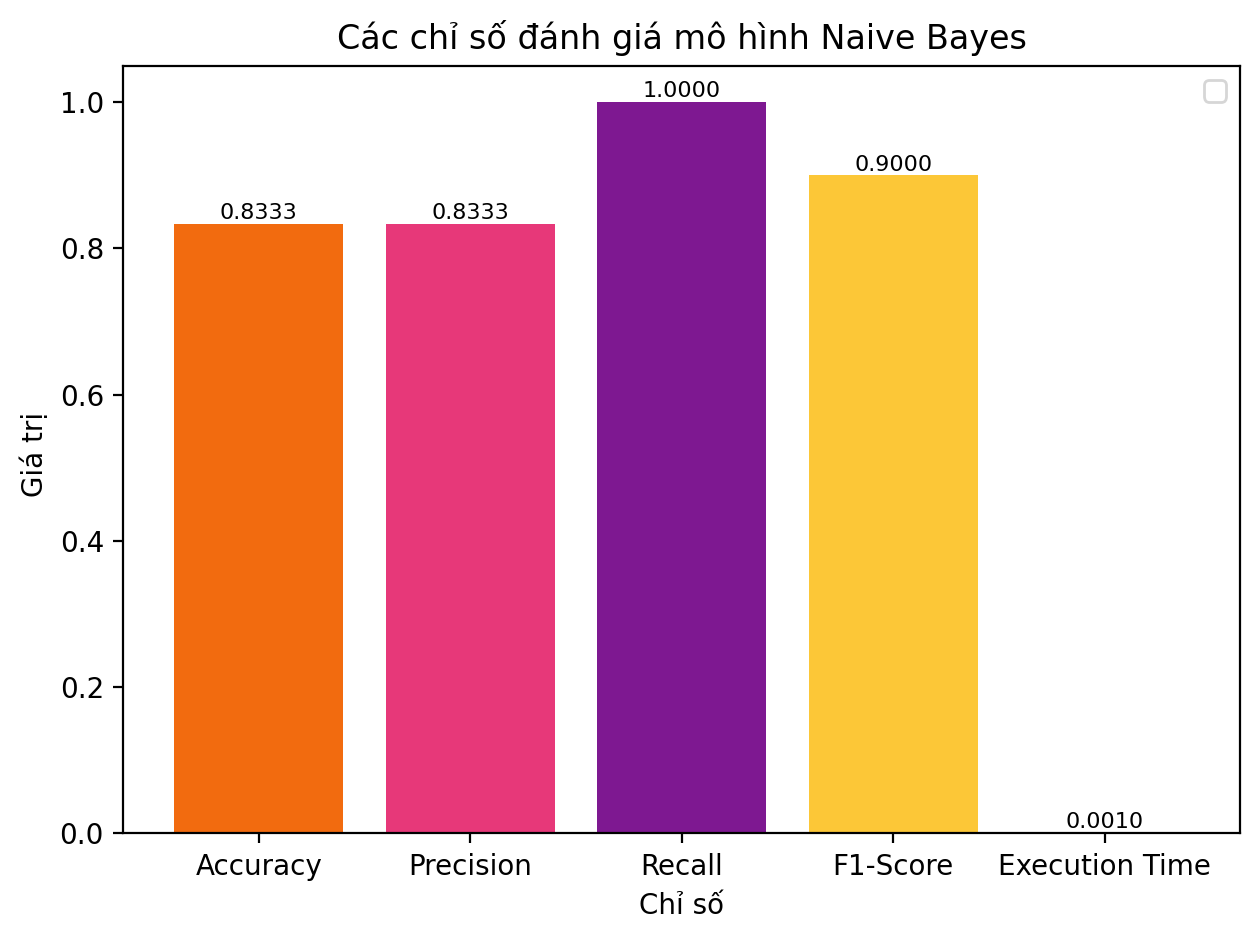

In [12]:
# Vẽ biểu đồ thể hiện các chỉ số
label_name = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Execution Time']

values = [acc_bayes, pre_bayes, rec_bayes, f1_bayes, execution_bayes]
colors = ['#F26B0F', '#E73879', '#7E1891', '#FCC737', '#131010']
fig, ax = plt.subplots(dpi = DPI)
rec = ax.bar(label_name, values, color = colors)
# Thêm tiêu đề cho biểu đồ
ax.set_ylabel('Giá trị ')
ax.set_xlabel('Chỉ số')
ax.set_title('Các chỉ số đánh giá mô hình Naive Bayes')
ax.set_xticks(np.arange(len(label_name)))
ax.legend()
for rect in rec:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.001, f'{height:.4f}', ha='center', va='bottom', fontsize=8)

fig.tight_layout()
# plt.savefig("Các chỉ số đánh giá mô hình Naive Bayes.png", transparent=True) # Lưu với nền trong suốt
plt.savefig("Các chỉ số đánh giá mô hình Naive Bayes.png", facecolor='White') # Lưu với nền màu Trắng
plt.show()


### Thực hiện lưu kết quả vào file csv

In [13]:
csv_file = "bayes_results.csv"
num_folds = len(parameters_bayes['accuracy'])

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Ghi header
    header = ['Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Execution Time']
    writer.writerow(header)

    # Ghi dữ liệu của từng fold, định dạng %
    for i in range(num_folds):
        row = [i + 1] # bắt đầu số fold từ 1
        for key, value in parameters_bayes.items():
            if key != 'execution-time':
                row.append(f"{round(value[i] * 100, 4)}%") # định dạng % và làm tròn
            else:
                row.append(f"{round(value[i], 4)}s") # chỉ làm tròn cho thời gian
        writer.writerow(row)

    # Tính trung bình của từng cột
    avg_row = ['Average']
    for key, value in parameters_bayes.items():
        if key != 'execution-time':
             avg = sum(value) / num_folds
             avg_row.append(f"{round(avg * 100, 4)}%") # làm tròn và định dạng %
        else:
            avg = sum(value) / num_folds
            avg_row.append(f"{round(avg, 4)}s") # chỉ làm tròn cho thời gian

    # Ghi dòng trung bình vào CSV
    writer.writerow(avg_row)

print(f"Dữ liệu đã được lưu vào file: {csv_file}")

Dữ liệu đã được lưu vào file: bayes_results.csv


In [14]:
try:
    # Đọc file CSV
    df = pd.read_csv('/kaggle/working/bayes_results.csv',
                     header = 0, 
                     sep = ',',
                     skipinitialspace = True)
    print('Đọc file thành công!')
    print(df)   
except FileNotFoundError:
    print(f"Lỗi: File '{PATH_FILE}' không tồn tại.")
except Exception:
    print(f"Lỗi {Exception}.")

Đọc file thành công!
      Fold  Accuracy Precision    Recall F1-Score Execution Time
0        1    100.0%    100.0%    100.0%   100.0%        0.0011s
1        2    100.0%    100.0%    100.0%   100.0%        0.0012s
2        3  66.6667%    100.0%  66.6667%    80.0%        0.0009s
3        4  66.6667%    100.0%  66.6667%    80.0%        0.0009s
4  Average  83.3333%    100.0%  83.3333%    90.0%         0.001s


### d. Sử dụng mô hình knn

In [15]:
# Khởi tạo dict chứa các chỉ số đánh giá của mô hình
parameters_knn = {
    'accuracy' : [],
    'recall' : [],
    'precision' : [],
    'f1-score' : [],
    'execution-time' : []
}

In [16]:
for i in range(K_FOLD):
    clf_knn = KNeighborsClassifier()         # Khởi tạo mô hình KNN
    start_knn = time.time() # Bắt đầu tính giờ
    # Huấn luyện mô hình
    clf_knn.fit(data_fold['X_train'][i], data_fold['y_train'][i])
    execution_time_knn = time.time() - start_knn      # Kết thúc thời gian huấn luyện

    
    # Dự đoán kết quả
    y_pred_knn = clf_knn.predict(data_fold['X_test'][i])

    # Tính các chỉ số đánh giá của mô hình
    acc = accuracy_score(data_fold['y_test'][i], y_pred_knn)
    rec = recall_score(data_fold['y_test'][i], y_pred_knn)
    f1 = f1_score(data_fold['y_test'][i], y_pred_knn)
    pre = precision_score(data_fold['y_test'][i], y_pred_knn)

    # Lưu kết quả
    parameters_knn['accuracy'].append(acc)
    parameters_knn['recall'].append(rec)
    parameters_knn['precision'].append(pre)
    parameters_knn['f1-score'].append(f1)
    parameters_knn['execution-time'].append(execution_time_knn)

    # In ra kết quả theo từng Fold
    print("FOLD:", i + 1)  # In số thứ tự của fold
    # Các chỉ số đánh giá
    print("{:<15}{:<15}{:<15}{:<15}{:<15}".format("Precision", "Recall", "F1-Score", "Accuracy", 'Execution Time'))
    # In kết quả
    print("{:<15}{:<15}{:<15}{:<15}{:<15}".format(
        f"{pre * 100:.4}%", f"{rec * 100:.4}%", f"{f1 * 100:.4}%", f"{acc * 100:.4}%", f"{execution_time_bayes:.4}s"
    ))
    print('-' * 80)

# Tính giá trị trung bình của các chỉ số
acc_knn = np.mean(parameters_knn['accuracy'])
rec_knn = np.mean(parameters_knn['recall'])
pre_knn = np.mean(parameters_knn['precision'])
f1_knn = np.mean(parameters_knn['f1-score'])
execution_knn = np.mean(parameters_knn['execution-time'])

FOLD: 1
Precision      Recall         F1-Score       Accuracy       Execution Time 
100.0%         50.0%          66.67%         66.67%         0.0008521s     
--------------------------------------------------------------------------------
FOLD: 2
Precision      Recall         F1-Score       Accuracy       Execution Time 
100.0%         100.0%         100.0%         100.0%         0.0008521s     
--------------------------------------------------------------------------------
FOLD: 3
Precision      Recall         F1-Score       Accuracy       Execution Time 
50.0%          50.0%          50.0%          33.33%         0.0008521s     
--------------------------------------------------------------------------------
FOLD: 4
Precision      Recall         F1-Score       Accuracy       Execution Time 
100.0%         100.0%         100.0%         100.0%         0.0008521s     
--------------------------------------------------------------------------------


In [17]:
csv_file = "knn_results.csv"
num_folds = len(parameters_knn['accuracy'])

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Ghi header
    header = ['Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Execution Time']
    writer.writerow(header)

    # Ghi dữ liệu của từng fold, định dạng %
    for i in range(num_folds):
        row = [i + 1] # bắt đầu số fold từ 1
        for key, value in parameters_bayes.items():
            if key != 'execution-time':
                row.append(f"{round(value[i] * 100, 4)}%") # định dạng % và làm tròn
            else:
                row.append(f"{round(value[i], 4)}s") # chỉ làm tròn cho thời gian
        writer.writerow(row)

    # Tính trung bình của từng cột
    avg_row = ['Average']
    for key, value in parameters_bayes.items():
        if key != 'execution-time':
             avg = sum(value) / num_folds
             avg_row.append(f"{round(avg * 100, 4)}%") # làm tròn và định dạng %
        else:
            avg = sum(value) / num_folds
            avg_row.append(f"{round(avg, 4)}s") # chỉ làm tròn cho thời gian

    # Ghi dòng trung bình vào CSV
    writer.writerow(avg_row)

print(f"Dữ liệu đã được lưu vào file: {csv_file}")

Dữ liệu đã được lưu vào file: knn_results.csv


In [18]:
try:
    # Đọc file CSV
    df = pd.read_csv('/kaggle/working/knn_results.csv',
                     header = 0, 
                     sep = ',',
                     skipinitialspace = True)
    print('Đọc file thành công!')
    print(df)
except FileNotFoundError:
    print(f"Lỗi: File '{PATH_FILE}' không tồn tại.")
except Exception:
    print(f"Lỗi {Exception}.")

Đọc file thành công!
      Fold  Accuracy Precision    Recall F1-Score Execution Time
0        1    100.0%    100.0%    100.0%   100.0%        0.0011s
1        2    100.0%    100.0%    100.0%   100.0%        0.0012s
2        3  66.6667%    100.0%  66.6667%    80.0%        0.0009s
3        4  66.6667%    100.0%  66.6667%    80.0%        0.0009s
4  Average  83.3333%    100.0%  83.3333%    90.0%         0.001s


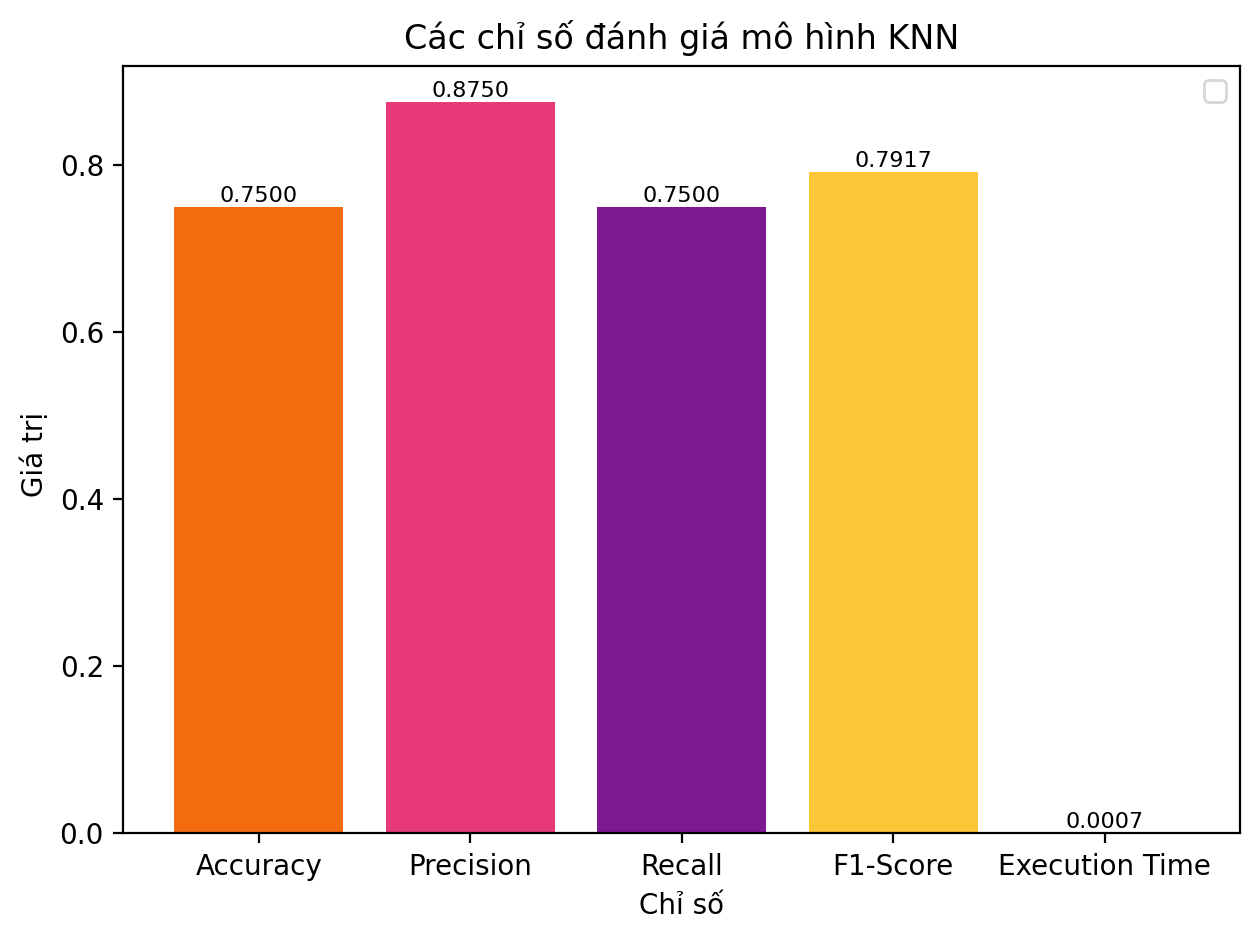

In [19]:
# Vẽ biểu đồ đánh giá các chỉ số
label_name = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Execution Time']

values = [acc_knn, pre_knn, rec_knn, f1_knn, execution_knn]
colors = ['#F26B0F', '#E73879', '#7E1891', '#FCC737', '#131010']
fig, ax = plt.subplots(dpi = DPI)
rec = ax.bar(label_name, values, color = colors)
# Thêm tiêu đề cho biểu đồ
ax.set_ylabel('Giá trị ')
ax.set_xlabel('Chỉ số')
ax.set_title('Các chỉ số đánh giá mô hình KNN')
ax.set_xticks(np.arange(len(label_name)))
ax.legend()
for rect in rec:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.001, f'{height:.4f}', ha='center', va='bottom', fontsize=8)

fig.tight_layout()
# plt.savefig("Các chỉ số đánh giá mô hình Naive Bayes.png", transparent=True) # Lưu với nền trong suốt
plt.savefig("Các chỉ số đánh giá mô hình KNN.png", facecolor='White') # Lưu với nền màu Trắng
plt.show()